# install dependency 


In [1]:
import tensorflow as tf
import os 
import matplotlib.pyplot as plt
import tensorflow_io as tfio 

/opt/miniconda3/envs/tensorflow/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/miniconda3/envs/tensorflow/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ["dlopen(/opt/miniconda3/envs/tensorflow/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so, 0x0006): symbol not found in flat namespace '__ZN3tsl8OkStatusEv'"]
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/miniconda3/envs/tensorflow/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/miniconda3/envs/tensorflow/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ["dlopen(/opt/miniconda3/envs/tensorflow/lib/python3.10/site-pa

# 2) building data loading function

In [2]:
BASE = os.path.join("data")
one_file = os.path.join(BASE,"Parsed_Capuchinbird_Clips")
zero_file = os.path.join(BASE,"Parsed_Not_Capuchinbird_Clips")

In [3]:
ex1 = os.path.join(one_file,"XC3776-1.wav")
ex0 = os.path.join(zero_file, "afternoon-birds-song-in-forest-0.wav")

### building fucntion to laod the data

In [4]:
# def load_wav_16k_mono(filename):
#     # Load encoded wav file
#     file_contents = tf.io.read_file(filename)
#     # Decode wav (tensors by channels) 
#     wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1)
#     # Removes trailing axis
#     wav = tf.squeeze(wav, axis=-1)
#     sample_rate = tf.cast(sample_rate, dtype=tf.int64)
#     # Goes from 44100Hz to 16000hz - amplitude of the audio signal
#     wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
#     return wav

# def load_wav_16k_mono(filename):
#     # Load encoded wav file
#     file_contents = tf.io.read_file(filename)
#     # Decode wav (tensors by channels) 
#     wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1)
#     # Removes trailing axis
#     wav = tf.squeeze(wav, axis=-1)
#     sample_rate = tf.cast(sample_rate, dtype=tf.int64)
#     # Goes from 44100Hz to 16000hz - amplitude of the audio signal
#     wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
#     return wav

In [5]:
file_contents = tf.io.read_file(ex1)
wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels = 1)

2024-09-24 22:13:27.087448: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2024-09-24 22:13:27.087466: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-09-24 22:13:27.087471: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-09-24 22:13:27.087507: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-09-24 22:13:27.087519: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [6]:
print(wav)

tf.Tensor(
[[0.12219238]
 [0.1296997 ]
 [0.12506104]
 ...
 [0.22250366]
 [0.21054077]
 [0.18322754]], shape=(132300, 1), dtype=float32)


In [7]:
import librosa

#function to sample the audio file
def load_wav_16k_mono(filename):
    wav, sample_rate = librosa.load(filename, sr=16000, mono=True)
    return wav

# def load_wav_16k_mono(filename):
#     # Load encoded wav file
#     file_contents = tf.io.read_file(filename)
#     # Decode wav (tensors by channels) 
#     wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1)
#     # Removes trailing axis
#     wav = tf.squeeze(wav, axis=-1)
#     sample_rate = tf.cast(sample_rate, dtype=tf.int64)
#     # Goes from 44100Hz to 16000hz - amplitude of the audio signal
#     wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
#     return wav


# def load_wav_16k_mono(filename):
#     # Load encoded wav file
#     file_contents = tf.io.read_file(filename)
#     # Decode wav (tensors by channels) 
#     wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1)
#     # Removes trailing axis
#     wav = tf.squeeze(wav, axis=-1)
#     sample_rate = tf.cast(sample_rate, dtype=tf.int64)
#     # Goes from 44100Hz to 16000hz - amplitude of the audio signal
#     wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
#     return wav

In [8]:
# ploating the wave
wave = load_wav_16k_mono(ex1)
nwave = load_wav_16k_mono(ex0)


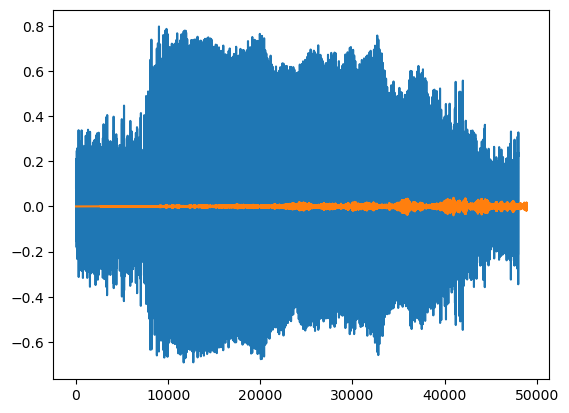

In [9]:
plt.plot(wave)
plt.plot(nwave)
plt.show()

## creating a tensorflow dataset

In [11]:
#defining the dataset path
POS = os.path.join('data','Parsed_Capuchinbird_Clips')
NOS = os.path.join('data','Parsed_Not_Capuchinbird_Clips')

pos = tf.data.Dataset.list_files(POS + '/*.wav')
nos = tf.data.Dataset.list_files(NOS + '/*.wav')

In [12]:
pos_path_lsit = []
nos_path_list = []
for path in os.listdir(POS):
    pos_path_lsit.append(POS+"/"+ path)
for path in os.listdir(NOS):
    nos_path_list.append(NOS+"/"+path)


In [13]:

# # Assuming POS and NOS are paths to the directories


# # Map a function to convert the file paths from bytes to strings
# pos = pos.map(lambda file_path: tf.strings.regex_replace(file_path, '', ''))
# nos = nos.map(lambda file_path: tf.strings.regex_replace(file_path, '', ''))

# # You can then iterate over the dataset and print the file paths
# for file_path in pos.take(5):  # Taking first 5 files as an example
#     print(file_path.numpy().decode('utf-8'))

# for file_path in nos.take(5):  # Taking first 5 files as an example
#     print(file_path.numpy().decode('utf-8'))

In [14]:
# POS_LIST = []
# for file_path in pos:
#     file_str = file_path.numpy().decode('utf-8')  # Convert tensor to string
#     POS_LIST.append(file_str)

# NOS_LIST = []
# for file_path in nos:
#     file_str = file_path.numpy().decode('utf-8')  # Convert tensor to string
#     NOS_LIST.append(file_str)
    

In [15]:
# x = tf.convert_to_tensor(POS_LIST)
# y = tf.convert_to_tensor(NOS_LIST)

In [16]:
# adding labels and positive and negative samples
positives = tf.data.Dataset.zip((pos, tf.data.Dataset.from_tensor_slices(tf.ones(len(pos)))))
negatives = tf.data.Dataset.zip((nos, tf.data.Dataset.from_tensor_slices(tf.ones(len(nos)))))
data = positives.concatenate(negatives)

In [17]:
for k in data.as_numpy_iterator():
    print(k)

(b'data/Parsed_Capuchinbird_Clips/XC3776-4.wav', 1.0)
(b'data/Parsed_Capuchinbird_Clips/XC3776-6.wav', 1.0)
(b'data/Parsed_Capuchinbird_Clips/XC3776-3.wav', 1.0)
(b'data/Parsed_Capuchinbird_Clips/XC3776-2.wav', 1.0)
(b'data/Parsed_Capuchinbird_Clips/XC3776-1.wav', 1.0)
(b'data/Parsed_Capuchinbird_Clips/XC3776-5.wav', 1.0)
(b'data/Parsed_Not_Capuchinbird_Clips/afternoon-birds-song-in-forest-0.wav', 1.0)
(b'data/Parsed_Not_Capuchinbird_Clips/afternoon-birds-song-in-forest-5.wav', 1.0)
(b'data/Parsed_Not_Capuchinbird_Clips/afternoon-birds-song-in-forest-3.wav', 1.0)
(b'data/Parsed_Not_Capuchinbird_Clips/afternoon-birds-song-in-forest-2.wav', 1.0)
(b'data/Parsed_Not_Capuchinbird_Clips/afternoon-birds-song-in-forest-4.wav', 1.0)
(b'data/Parsed_Not_Capuchinbird_Clips/afternoon-birds-song-in-forest-1.wav', 1.0)


2024-09-24 22:13:33.755309: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [18]:
# for i in data.as_numpy_iterator():
#     print(str(i[0]))
#     # Convert bytes to string
#     byte_data = i[0]
#     string_data = byte_data.decode('utf-8')
#     print(f"the str data is : {string_data}")
#     break

In [19]:
positives.as_numpy_iterator().next()

(b'data/Parsed_Capuchinbird_Clips/XC3776-2.wav', 1.0)

In [20]:
negatives.as_numpy_iterator().next()

(b'data/Parsed_Not_Capuchinbird_Clips/afternoon-birds-song-in-forest-1.wav',
 1.0)

## 4) determining each call

In [21]:
# calculating wave cycle length
lengths = []
for file in os.listdir(os.path.join('data','Parsed_Capuchinbird_Clips')):
    tensor_wave = load_wav_16k_mono(os.path.join('data', 'Parsed_Capuchinbird_Clips', file ))
    lengths.append(len(tensor_wave))

/var/folders/xb/sshzwv1128l88chp71np05t40000gn/T/ipykernel_27560/134147184.py:5: UserWarning: PySoundFile failed. Trying audioread instead.
  wav, sample_rate = librosa.load(filename, sr=16000, mono=True)
/opt/miniconda3/envs/tensorflow/lib/python3.10/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


NoBackendError: 

In [40]:
cycle_value = tf.math.reduce_mean(lengths)

In [22]:
print(f"the average call is of {cycle_value/16000} seconds.")

NameError: name 'cycle_value' is not defined

In [23]:
tf.math.reduce_min(lengths)

<tf.Tensor: shape=(), dtype=float32, numpy=inf>

In [24]:
tf.math.reduce_max(lengths)

<tf.Tensor: shape=(), dtype=float32, numpy=-inf>

## function to convert to spectrogram

In [25]:
def preprocess(file_path, label): 
    wav = load_wav_16k_mono(file_path)
    wav = wav[:48000]
    zero_padding = tf.zeros([48000] - tf.shape(wav), dtype=tf.float32)
    wav = tf.concat([zero_padding, wav],0)
    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    return spectrogram, label

### 5.1) testing out the function and visualising the spectrogram

In [26]:
filepath, label = positives.shuffle(buffer_size=10000).as_numpy_iterator().next()

In [27]:
filepath

b'data/Parsed_Capuchinbird_Clips/XC3776-5.wav'

In [28]:
label

1.0

In [29]:
filepath = pos_path_lsit[1]
label = 1.0

In [30]:
filepath

'data/Parsed_Capuchinbird_Clips/XC3776-3.wav'

In [31]:
spectrogram, label = preprocess(filepath, label)

In [32]:
spectrogram

<tf.Tensor: shape=(1491, 257, 1), dtype=float32, numpy=
array([[[3.52036208e-03],
        [1.10032340e-03],
        [5.79676731e-03],
        ...,
        [1.05447536e-04],
        [1.07919564e-04],
        [7.14138150e-05]],

       [[3.73379141e-03],
        [2.78371852e-03],
        [3.54832900e-03],
        ...,
        [8.43108792e-05],
        [8.46294715e-05],
        [2.41175294e-05]],

       [[2.82984972e-03],
        [1.05639256e-03],
        [9.61462967e-03],
        ...,
        [1.82204545e-04],
        [1.61108066e-04],
        [7.82608986e-05]],

       ...,

       [[3.71336937e-03],
        [6.77364413e-03],
        [1.34945465e-02],
        ...,
        [1.83109441e-04],
        [8.21772846e-05],
        [1.62139535e-04]],

       [[6.66428357e-04],
        [3.54610966e-03],
        [1.09554157e-02],
        ...,
        [4.12748806e-04],
        [1.53926274e-04],
        [5.86621463e-05]],

       [[5.15406206e-03],
        [4.53031017e-03],
        [5.70572633e-03]

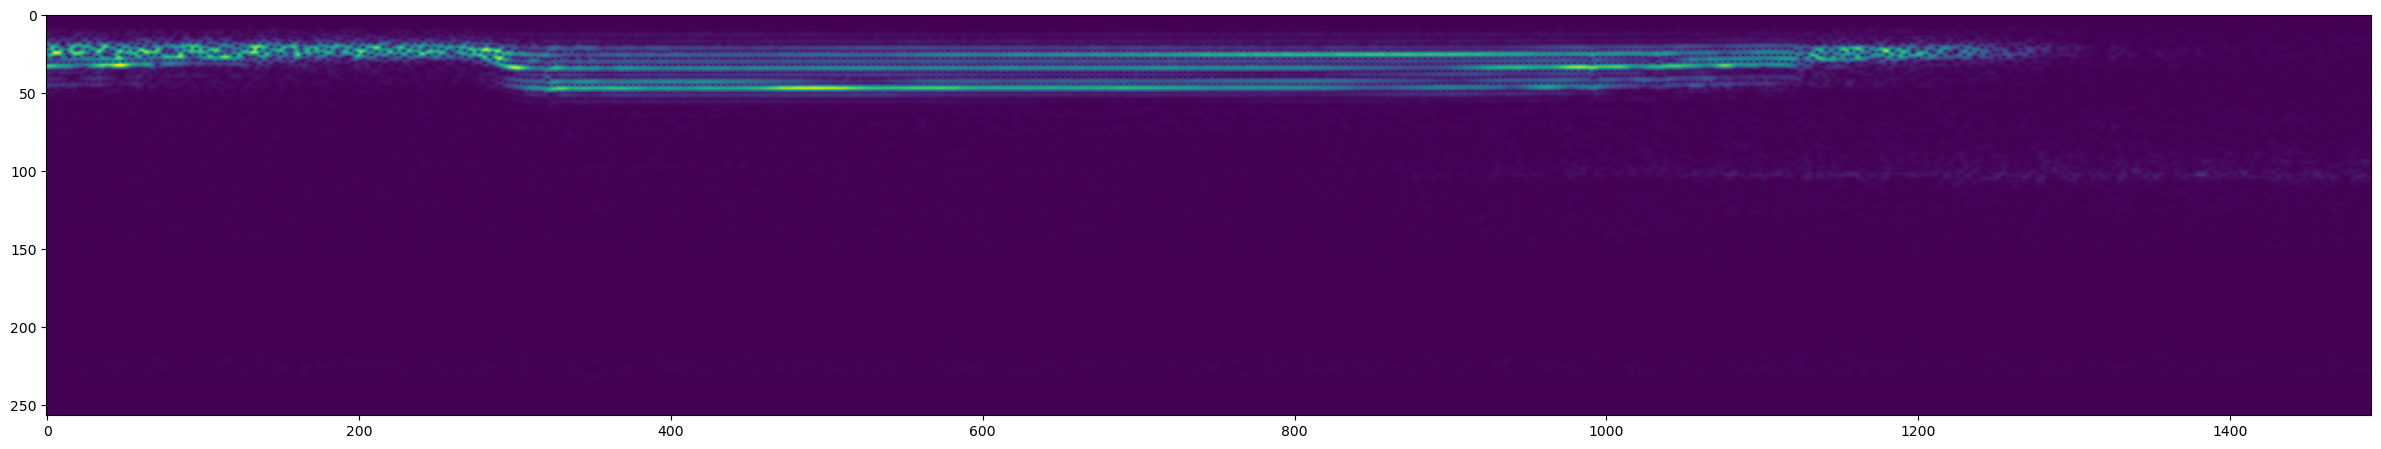

tf.Tensor(
[[[3.52036208e-03]
  [1.10032340e-03]
  [5.79676731e-03]
  ...
  [1.05447536e-04]
  [1.07919564e-04]
  [7.14138150e-05]]

 [[3.73379141e-03]
  [2.78371852e-03]
  [3.54832900e-03]
  ...
  [8.43108792e-05]
  [8.46294715e-05]
  [2.41175294e-05]]

 [[2.82984972e-03]
  [1.05639256e-03]
  [9.61462967e-03]
  ...
  [1.82204545e-04]
  [1.61108066e-04]
  [7.82608986e-05]]

 ...

 [[3.71336937e-03]
  [6.77364413e-03]
  [1.34945465e-02]
  ...
  [1.83109441e-04]
  [8.21772846e-05]
  [1.62139535e-04]]

 [[6.66428357e-04]
  [3.54610966e-03]
  [1.09554157e-02]
  ...
  [4.12748806e-04]
  [1.53926274e-04]
  [5.86621463e-05]]

 [[5.15406206e-03]
  [4.53031017e-03]
  [5.70572633e-03]
  ...
  [2.90405238e-04]
  [1.02677433e-04]
  [6.18360937e-05]]], shape=(1491, 257, 1), dtype=float32)


In [33]:
plt.figure(figsize=(30,20))
plt.imshow(tf.transpose(spectrogram)[0])
plt.show()

print(spectrogram)

# 6)creating training and testing prtition

### 6.1) creating tensorflow data pipeline

In [62]:
for filepath, label in data.take(1):
    print("Filepath:", filepath.numpy(), "Label:", label.numpy())

Filepath: b'data/Parsed_Capuchinbird_Clips/XC3776-4.wav' Label: 1.0


2024-09-23 21:15:56.708020: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [71]:
data = data.map(preprocess)
data = data.cache()
data = data.shuffle(buffer_size=1000)
data = data.batch(16)
data = data.prefetch(8)

TypeError: in user code:

    File "/var/folders/xb/sshzwv1128l88chp71np05t40000gn/T/ipykernel_23642/3763039504.py", line 2, in preprocess  *
        wav = load_wav_16k_mono(file_path)
    File "/var/folders/xb/sshzwv1128l88chp71np05t40000gn/T/ipykernel_23642/134147184.py", line 5, in load_wav_16k_mono  *
        wav, sample_rate = librosa.load(filename, sr=16000, mono=True)
    File "/opt/miniconda3/envs/tensorflow/lib/python3.10/site-packages/librosa/core/audio.py", line 176, in load  *
        y, sr_native = __soundfile_load(path, offset, duration, dtype)
    File "/opt/miniconda3/envs/tensorflow/lib/python3.10/site-packages/librosa/core/audio.py", line 209, in __soundfile_load  *
        context = sf.SoundFile(path)
    File "/opt/miniconda3/envs/tensorflow/lib/python3.10/site-packages/soundfile.py", line 658, in __init__  **
        self._file = self._open(file, mode_int, closefd)
    File "/opt/miniconda3/envs/tensorflow/lib/python3.10/site-packages/soundfile.py", line 1212, in _open
        raise TypeError("Invalid file: {0!r}".format(self.name))

    TypeError: Invalid file: <tf.Tensor 'args_0:0' shape=() dtype=string>


In [43]:
train  = data.take(36)
test = data.skip(36).take(15)

### 6.3) testing one batch

In [44]:
samples, labels = train.as_numpy_iterator().next()

In [46]:
samples.shape

AttributeError: 'bytes' object has no attribute 'shape'